# ADCP

In [1]:
import pandas as pd


def read_sheet(fname, sheet_name):
    df = pd.read_excel(
        fname,
        sheet_name=sheet_name,
        skiprows=20,
        na_values=-999.0,
    ).dropna(axis=1, how="all")
    index = pd.to_datetime(
        {
            "year": df["Ano"],
            "month": df["Mes"],
            "day": df["Dia"],
            "hour": df["Hora"],
        },
    )
    df.index = index
    return df.drop(["Ano", "Mes", "Dia", "Hora"], axis=1)

In [2]:
adp = read_sheet("Dados_brutos_Maare_2016_HDM.xlsx", sheet_name="Corrente")
ele = read_sheet("Dados_brutos_Maare_2016_HDM.xlsx", sheet_name="Nivel_Temp")

df = pd.concat([ele, adp], axis=1)
# not sure but those look like local time UTC-3
df.index = df.index + pd.DateOffset(hours=3)

In [3]:
import utide


time = df.index.to_numpy()
elev = df["AltColAgua(m)"]

coef = utide.solve(
    time,
    elev,
    lat=-27.253183,
    method="robust",
    conf_int="MC",
    verbose=False,
)



def summary_table(coef):
    summary = pd.DataFrame(coef["diagn"])
    summary["frq"] = coef["aux"]["frq"]
    summary["A"] = coef["A"]
    summary["A_ci"] = coef["A_ci"]
    summary["g"] = coef["g"]
    summary["g_ci"] = coef["g_ci"]
    summary = summary.set_index("name")
    return summary.sort_values(by="A", ascending=False)

## Summário das marés das observações no Arvoredo

In [4]:
summary_table(coef).head(10)

,PE,SNR,frq,A,A_ci,g,g_ci
name,,,,,,,
M2,43.282414,1.514963e+06,0.080511,0.222362,0.000354,150.209470,0.091418
S2,19.603819,1.241444e+06,0.083333,0.149650,0.000263,150.363287,0.121513
SA,10.647821,5.897469e+02,0.000114,0.110290,0.008901,98.620615,5.582527
O1,10.145117,1.810495e+05,0.038731,0.107655,0.000496,115.025465,0.200271
K1,3.572393,1.109974e+05,0.041781,0.063883,0.000376,176.409971,0.409474
SSA,2.301760,1.214835e+02,0.000228,0.051278,0.009119,161.559578,11.319323
K2,1.960786,7.146836e+04,0.083561,0.047328,0.000347,141.797591,0.432628
M4,1.641698,3.002849e+04,0.161023,0.043306,0.000490,251.773943,0.566902
N2,1.349750,5.583003e+04,0.078999,0.039267,0.000326,221.476347,0.544395


In [5]:
from utide import reconstruct


tide = reconstruct(time, coef)

prep/calcs ... done.


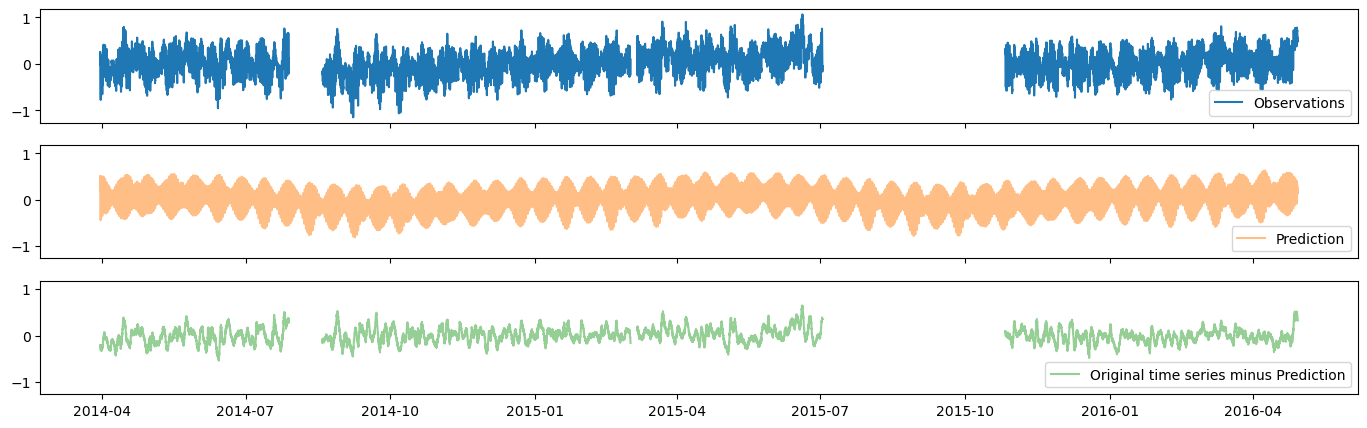

In [6]:
import numpy as np
import matplotlib.pyplot as plt


fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(time, elev-np.mean(elev), label="Observations", color="C0")
ax0.legend(numpoints=1, loc="lower right")

ax1.plot(time, tide["h"]-np.mean(tide["h"]), alpha=0.5, label="Prediction", color="C1")
ax1.legend(numpoints=1, loc="lower right")

ax2.plot(time, elev-tide["h"], alpha=0.5, label="Original time series minus Prediction", color="C2")
ax2.legend(numpoints=1, loc="lower right");

# Model

In [7]:
import pooch


url = f"https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/model_tides_and_wind.nc4",
    known_hash="sha256:f3c5fd95ccffb9baea40aa431f6e0946cb2f49ea07274083e5d704e8099ea4c6",
)

In [8]:
import cf_xarray
import xarray as xr


ds = xr.open_dataset(fname)

In [9]:
import numpy as np


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


lon, lat = -48.401215, -27.253183

m = find_nearest(ds["m"], lon)
n = find_nearest(ds["n"], lat)
serie = ds.isel(m=m, n=n)

In [10]:
time = serie["time"].to_numpy()
h = serie["waterlevel"].to_numpy()


coef = utide.solve(
    time,
    h,
    lat=-27.253183,
    method="robust",
    conf_int="MC",
    verbose=False,
)



def summary_table(coef):
    summary = pd.DataFrame(coef["diagn"])
    summary["frq"] = coef["aux"]["frq"]
    summary["A"] = coef["A"]
    summary["A_ci"] = coef["A_ci"]
    summary["g"] = coef["g"]
    summary["g_ci"] = coef["g_ci"]
    summary = summary.set_index("name")
    return summary.sort_values(by="A", ascending=False)

## Summário das marés do modelo na região do Arvoredo

In [11]:
summary_table(coef).head(10)

,PE,SNR,frq,A,A_ci,g,g_ci
name,,,,,,,
M2,50.852310,1.762876e+07,0.080511,0.226675,0.000106,154.452959,0.031278
S2,22.314397,8.330847e+06,0.083333,0.150155,0.000102,153.772423,0.043150
O1,11.461439,4.243697e+05,0.038731,0.107614,0.000324,113.883027,0.172444
SA,4.310640,1.030810e+02,0.000114,0.065996,0.012740,126.356435,7.508181
K1,3.821000,1.245594e+05,0.041781,0.062135,0.000345,177.069503,0.276037
K2,2.031488,7.327746e+05,0.083561,0.045306,0.000104,146.272240,0.148280
N2,1.467177,6.168795e+05,0.078999,0.038502,0.000096,225.604046,0.147184
SSA,1.249678,3.576044e+01,0.000228,0.035534,0.011647,141.936985,18.693650
Q1,0.822046,3.268298e+04,0.037219,0.028820,0.000312,89.008053,0.581482
